# ROB 498-011/599-011 Project 4: Scene Understanding - NERFs
Before we start, please put your name and UMID in following format

: Michael GUERTLER, #27385454   //   e.g.) Anthony OPIPARI, #12345678

# NeRF: Representing Scenes as Neural Radiance Fields for View Synthesis
In this project, you will develop a fully immersive scene representation model, leveraging Neural Radiance Fields [(NeRF)](https://arxiv.org/abs/2003.08934), which encapsulates the entire process of constructing and rendering 3D environments from 2D image data. The core of this model involves a dense sampling strategy that uses a neural network to predict the color and volume density of points in 3D space, which are then used to produce photorealistic images via differentiable volume rendering.

Due to resource limitations it will not be a complete implementation but a simplified version called tiny nerf.

# Getting Started

## Setup Code
Before getting started, we need to run some boilerplate code to set up our environment, same as previous assignments. You'll need to rerun this setup code each time you start the notebook.

First, run this cell load the autoreload extension. This allows us to edit .py source files, and re-import them into the notebook for a seamless editing and debugging experience.

In [ ]:
%load_ext autoreload
%autoreload 2

### Google Colab Setup
Next we need to run a few commands to set up our environment on Google Colab. If you are running this notebook on a local machine you can skip this section.

Run the following cell to mount your Google Drive. Follow the link, sign in to your Google account (the same account you used to store this notebook!) and copy the authorization code into the text box that appears below.

In [ ]:
running_colab = 'google.colab' in str(get_ipython())

if running_colab:
    from google.colab import drive
    drive.mount('/content/drive')
else:
    print('Running locally')

Mounted at /content/drive


Now recall the path in your Google Drive where you uploaded this notebook, fill it in below. If everything is working correctly then running the following cell should print the filenames from the assignment:

```
['p4_helper.py', 'tiny_nerf_pytorch.ipynb', 'test_ray_o.pt', 'test_ray_d.pt', 'tiny_nerf.py']
```

In [ ]:
import os
import sys

# TODO: Fill in the Google Drive/Local path where you uploaded the assignment
# Example: If you create a 2024WN folder and put all the files under P3 folder, then "2024WN/P4"
# GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = '2024WN/P4'
if running_colab:
    GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = None
    GOOGLE_DRIVE_PATH = os.path.join("drive", "My Drive", "599 - Deep Learning/P4")
else:
    GOOGLE_DRIVE_PATH = os.path.join(r'/home/Documents/deeprob/Homework/tiny_nerf_pytorch/')

print(os.listdir(GOOGLE_DRIVE_PATH))

# Add to sys so we can import .py files.
sys.path.append(GOOGLE_DRIVE_PATH)

['test_ray_d.pt', 'p4_helper.py', 'test_ray_o.pt', '__pycache__', 'nerf.pth', 'tiny_nerf.py', 'pred_image.pt', 'tiny_nerf_pytorch.ipynb']


Next we will import a few packages

In [ ]:
import os, sys
from tqdm import tqdm_notebook as tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import time

### Download Data

In [ ]:
if not os.path.exists('tiny_nerf_data.npz'):
    !wget http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz

--2024-03-26 17:37:13--  http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz
Resolving cseweb.ucsd.edu (cseweb.ucsd.edu)... 132.239.8.30
Connecting to cseweb.ucsd.edu (cseweb.ucsd.edu)|132.239.8.30|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cseweb.ucsd.edu//~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz [following]
--2024-03-26 17:37:14--  https://cseweb.ucsd.edu//~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz
Connecting to cseweb.ucsd.edu (cseweb.ucsd.edu)|132.239.8.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12727482 (12M)
Saving to: ‘tiny_nerf_data.npz’

tiny_nerf_data.npz  100%[===================>]  12.14M  --.-KB/s    in 0.1s    

2024-03-26 17:37:14 (113 MB/s) - ‘tiny_nerf_data.npz’ saved [12727482/12727482]



### Setting our device

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device is set to: ', device)

Device is set to:  cuda


# Load the data

Here we have 106 images of a block toy construction vehicle. The data includes the RGB image, pose, and focal point. We visualize one of the images.

torch.Size([106, 100, 100, 3]) torch.Size([106, 4, 4]) tensor(138.8889, device='cuda:0', dtype=torch.float64)


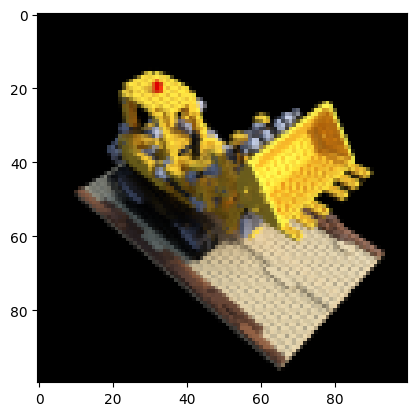

In [ ]:
data = np.load('tiny_nerf_data.npz')
images = torch.tensor(data['images'],device=device)
poses = torch.tensor(data['poses'],device=device)
focal = torch.tensor(data['focal'],device=device)
H, W = images.shape[1:3]
print(images.shape, poses.shape, focal)

testimg, testpose = images[101], poses[101]
images = images[:100,...,:3]
poses = poses[:100]

plt.imshow(testimg.detach().cpu().numpy())
plt.show()

# Implementation
Homework has 3 parts to complete:
1. Encoding fucntion
2. Get rays function
3. Nerf class


## Fill in positional_encoding
The function positional_encoding applies a positional encoding transformation to the input tensor x using sine and cosine functions. The scaled sine and cosine functions help the model to distinguish between different positions more effectively.

### Steps to Implement:
1. Initialize encodings with the original input tensor x
2. For each frequency band (up to num_embed), calculate sine and cosine encodings of x scaled by `2**i`, where i is the current frequency band index.
4. Concatenate all encodings along the last dimension to produce the final encoded tensor.


In [ ]:
from tiny_nerf import positional_encoding
from p4_helper import *
test_points = torch.tensor([[1.1,2.2,3.3],[55,33,16]])
num_embed = 5
endcoding = positional_encoding(test_points, num_embed)
print("Input shape: [2,3]")
print("Expected shape: [2, 33]")
print("Encoding shape: ", endcoding.shape)


Input shape: [2,3]
Expected shape: [2, 33]
Encoding shape:  torch.Size([2, 33])


## Fill in get_rays fucntion

The function get_rays is designed to calculate the origins and directions of rays emanating from the camera's viewpoint in a 3D scene, a critical step in the rendering process of neural radiance fields (NeRF) and other 3D reconstruction tasks.

Parameter Definition:
* H: The height of the image in pixels.
* W: The width of the image in pixels.
* focal: The focal length of the camera, which influences the field of view.
* c2w: The camera-to-world transformation matrix, which positions the camera in the scene.

### Steps to Implement:

1. Pixel Grid: Create a grid representing the pixel coordinates of your image. This can be achieved by creating a meshgrid of pixel indices, with dimensions matching your image.

2. Normalizing Pixel Coordinates: Normalize the pixel coordinates to convert them from image space to camera space. This involves shifting the coordinates so that the origin is at the center of the image and then scaling by the focal length. The normalized coordinates (x, y) for a pixel (i, j) can be calculated as:
$$
x=(i−width/2)/(focal\_length) \\
y=(j−height/2)/(focal\_length​)
$$
3. Direction Vectors: Construct direction vectors for each ray. In camera space, these can initially be represented as having components [x, y, -1], assuming the camera looks towards the negative z-axis. The -1 accounts for the fact that in many camera coordinate systems, the z-axis points out of the camera into the scene.

4. Transforming to World Space: Transform the direction vectors from camera space to world space using the camera's rotation matrix (part of the camera's extrinsic parameters). This involves a matrix-vector multiplication for each direction vector.

5. Ray Origins: The origin of each ray is the camera's position in the world, which can be obtained from the camera's extrinsic parameters.

6. Putting It All Together: For each pixel in your image, you now have a ray defined by its origin and direction in world space. These rays can be used for volume rendering in the NeRF framework.

You should get a relative differnce less than `1e-6`.

In [ ]:
from tiny_nerf import get_rays
from p4_helper import *
pose = poses[0]

rays_o, rays_d = get_rays(100, 100, focal, pose)
rays_d_ans = torch.load(os.path.join(GOOGLE_DRIVE_PATH, "test_ray_d.pt")).to(device)
rays_o_ans = torch.load(os.path.join(GOOGLE_DRIVE_PATH,"test_ray_o.pt")).to(device)

print("Expected ray_o, ray_d shape: [100, 100, 3]")
print("rays_o shape: ", rays_o.shape)
print("rays_d shape: ", rays_d.shape)

print('Relative differnce in ray_d: ', rel_error(rays_d,rays_d_ans))
print('Relative differnce in ray_o: ', rel_error(rays_o,rays_o_ans))

Expected ray_o, ray_d shape: [100, 100, 3]
rays_o shape:  torch.Size([100, 100, 3])
rays_d shape:  torch.Size([100, 100, 3])
Relative differnce in ray_d:  5.5874668202251545e-08
Relative differnce in ray_o:  0.0


## Fill in Nerf class
The nerf class defined here is a PyTorch module designed to represent a simplified version of a Neural Radiance Field (NeRF) model. The class uses fully connected layers to process the input, with optional positional encoding for the inputs.

### Description:

1. The input is processed through each layer, applying a ReLU activation function after each one.
2. Every `4th` layer after the first (i.e. [5, 9, 13...]), the original input is concatenated with the current layer's output.
3. The last layer does not have a ReLU.

## Render Rays function

To simplify the project the render_rays has been written for you. Please take a look at what it does and how it does it.

The render_rays function is designed for volume rendering. It takes a set of rays defined by their origins and directions, samples points along these rays, queries a neural network to obtain color and density values at these points, and then integrates these values along the rays to produce rendered images.

# Calling the Model and setting parameters

In [ ]:
from tiny_nerf import *
model = nerf(depth=8, width=256, num_embed=6)
optimizer = optim.Adam(model.parameters(), lr=5e-4)
model.to(device)
print('If not already set, please change to GPU (cuda) for training the model')
print('Device is set to: ', device)
assert(str(device) == 'cuda')

If not already set, please change to GPU (cuda) for training the model
Device is set to:  cuda


## Training the model
This willl train with 100 images for 4000 iterations at approx ~0.65sec/it (~45 min on colab). At every 100 iterations it will render an image at a pose that it has not trained on. The Peak signal-to-noise ratio (PSNR) is plotted next to it see [wikipedia](https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio) for more info.

The first couple of hundres of iterations may be blury but at iteration ~300 rough shapes should start being apparent.

In [ ]:

N_samples = 64
N_iters = 4000
psnrs = []
iternums = []
i_plot = 100

t = time.time()
for i in range(N_iters + 1):

    img_i = np.random.randint(images.shape[0])
    target = images[img_i]
    pose = poses[img_i]
    rays_o, rays_d = get_rays(H, W, focal, pose)

    optimizer.zero_grad()
    rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples, rand=True)
    loss = torch.mean((rgb - target) ** 2)
    loss.backward()
    optimizer.step()

    if i % i_plot == 0:
        print(i, (time.time() - t) / i_plot, 'secs per iter')
        t = time.time()

        # Render the holdout view for logging
        testpose_tensor = testpose
        rays_o, rays_d = get_rays(H, W, focal, testpose_tensor)
        with torch.no_grad():
            rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples)

        testimg_tensor = testimg
        loss = torch.mean((rgb - testimg_tensor) ** 2)
        psnr = -10. * torch.log10(loss)

        psnrs.append(psnr.item())
        iternums.append(i)

        plt.figure(figsize=(10, 4))
        plt.subplot(121)
        plt.imshow(rgb.cpu().numpy())
        plt.title(f'Iteration: {i}')
        plt.subplot(122)
        plt.plot(iternums, psnrs)
        plt.title('PSNR')
        plt.show()
print("Final Loss: ", loss.item())
print('Done')


Output hidden; open in https://colab.research.google.com to view.

## Save the model

In [ ]:
torch.save(model.state_dict(), os.path.join(GOOGLE_DRIVE_PATH,"nerf.pth"))

## Save an tensor for grading

In [ ]:
model = nerf(depth=8, width=256, num_embed=6)
model.load_state_dict(torch.load(os.path.join(GOOGLE_DRIVE_PATH,'nerf.pth')))
model.to(device)

test_pose = torch.tensor(data['poses'],device=device)[102]

rays_o, rays_d = get_rays(H, W, focal, test_pose)
with torch.no_grad():
    rgb, _, _ = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples)

torch.save(rgb.cpu(),os.path.join(GOOGLE_DRIVE_PATH,'pred_image.pt'))

# Submit your work
Submit your python, notebook, pred_image and model to autograder

# Optional Visualisation

## Load the model

In [ ]:
model =  nerf(depth=8, width=256, num_embed=6)
model.load_state_dict(torch.load(os.path.join(GOOGLE_DRIVE_PATH,'nerf.pth')))
model.to(device)

nerf(
  (model): Sequential(
    (0): Linear(in_features=39, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=295, out_features=256, bias=True)
    (9): ReLU()
    (10): Linear(in_features=256, out_features=256, bias=True)
    (11): ReLU()
    (12): Linear(in_features=256, out_features=256, bias=True)
    (13): ReLU()
    (14): Linear(in_features=256, out_features=256, bias=True)
    (15): ReLU()
    (16): Linear(in_features=256, out_features=4, bias=True)
  )
)

## Interactive Visualization

In [ ]:
%matplotlib inline
from ipywidgets import interactive, widgets
N_samples = 64


trans_t = lambda t : torch.tensor([
    [1,0,0,0],
    [0,1,0,0],
    [0,0,1,t],
    [0,0,0,1],
], dtype=torch.float32)

rot_phi = lambda phi : torch.tensor([
    [1,0,0,0],
    [0,np.cos(phi),-np.sin(phi),0],
    [0,np.sin(phi), np.cos(phi),0],
    [0,0,0,1],
], dtype=torch.float32)

rot_theta = lambda th : torch.tensor([
    [np.cos(th),0,-np.sin(th),0],
    [0,1,0,0],
    [np.sin(th),0, np.cos(th),0],
    [0,0,0,1],
], dtype=torch.float32)


def pose_spherical(theta, phi, radius):
    c2w = trans_t(radius)
    c2w = rot_phi(phi/180.*np.pi) @ c2w
    c2w = rot_theta(theta/180.*np.pi) @ c2w
    c2w = np.array([[-1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]]) @ c2w.numpy()
    return torch.tensor(c2w,dtype=torch.float32,device=device)


def f(**kwargs):
    c2w = pose_spherical(**kwargs)
    rays_o, rays_d = get_rays(H, W, focal, c2w[:3,:4])
    rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples)
    img = torch.clip(rgb,0,1)

    plt.figure(2, figsize=(20,6))
    plt.imshow(img.detach().cpu().numpy())
    plt.show()


sldr = lambda v, mi, ma: widgets.FloatSlider(
    value=v,
    min=mi,
    max=ma,
    step=.01,
)

names = [
    ['theta', [100., 0., 360]],
    ['phi', [-30., -90, 0]],
    ['radius', [4., 3., 5.]],
]

interactive_plot = interactive(f, **{s[0] : sldr(*s[1]) for s in names})
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(FloatSlider(value=100.0, description='theta', max=360.0, step=0.01), FloatSlider(value=-…

## Creating a video

In [ ]:
frames = []
for th in tqdm(np.linspace(0., 360., 120, endpoint=False)):
    c2w = pose_spherical(th, -30., 4.)
    rays_o, rays_d = get_rays(H, W, focal, c2w[:3,:4])
    rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples)
    frames.append((255*np.clip(rgb.detach().cpu().numpy(),0,1)).astype(np.uint8))

import imageio
f = os.path.join(GOOGLE_DRIVE_PATH,'video.mp4')
imageio.mimwrite(f, frames, fps=30, quality=7)